In [ ]:
import itertools
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [ ]:
df = pd.read_excel("/content/Weekly_Natural_Gas_Spot_Price.xlsx", index_col="Date", header=0, parse_dates=True)

In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df, head=10)

##################### Shape #####################
(1360, 1)
##################### Types #####################
Weekly Henry Hub Natural Gas Spot Price (Dollars per Million Btu)    float64
dtype: object
##################### Head #####################
            Weekly Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
Date                                                                         
1997-01-10                                               3.79                
1997-01-17                                               4.19                
1997-01-24                                               2.98                
1997-01-31                                               2.91                
1997-02-07                                               2.53                
1997-02-14                                               2.30                
1997-02-21                                               1.91                
1997-02-28                                      

In [ ]:
df_1 = df.copy()
df_1

,Weekly Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
Date,
1997-01-10,3.79
1997-01-17,4.19
1997-01-24,2.98
1997-01-31,2.91
1997-02-07,2.53
...,...
2023-01-06,3.65
2023-01-13,3.46
2023-01-20,3.17


In [ ]:
df.columns

Index(['Weekly Henry Hub Natural Gas Spot Price (Dollars per Million Btu)'], dtype='object')

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Weekly Henry Hub Natural Gas Spot Price (Dollars per Million Btu),1360.0,4.248574,2.194045,1.34,2.7,3.615,5.41,14.49


In [ ]:
df.info

<bound method DataFrame.info of             Weekly Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
Date                                                                         
1997-01-10                                               3.79                
1997-01-17                                               4.19                
1997-01-24                                               2.98                
1997-01-31                                               2.91                
1997-02-07                                               2.53                
...                                                       ...                
2023-01-06                                               3.65                
2023-01-13                                               3.46                
2023-01-20                                               3.17                
2023-01-27                                               3.08                
2023-02-03                      

<function matplotlib.pyplot.show(close=None, block=None)>

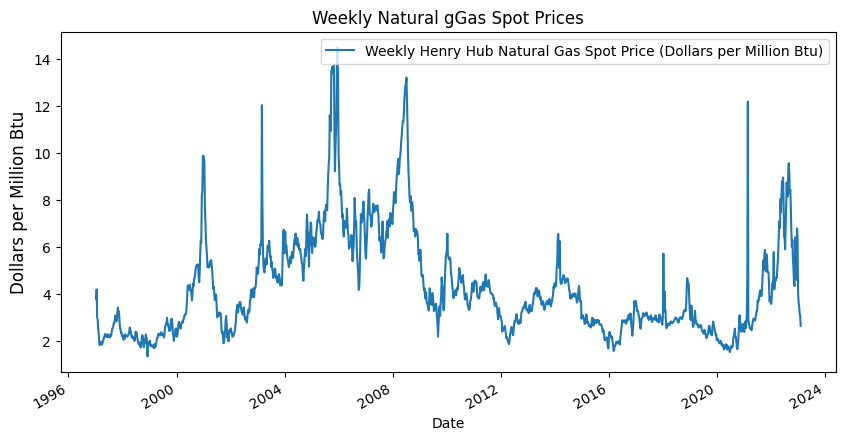

In [ ]:
df.plot(figsize=(10, 5))
plt.title("Weekly Natural gGas Spot Prices", fontsize=12)
plt.ylabel("Dollars per Million Btu", fontsize=12)
plt.show

In [ ]:
num_cols = [col for col in df.columns if df[col].dtypes != "O"]

In [ ]:
num_cols

['Weekly Henry Hub Natural Gas Spot Price (Dollars per Million Btu)']

In [ ]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [ ]:
outlier_thresholds(df, num_cols, q1=0.25, q3=0.75)

(Weekly Henry Hub Natural Gas Spot Price (Dollars per Million Btu)   -1.365
 dtype: float64,
 Weekly Henry Hub Natural Gas Spot Price (Dollars per Million Btu)    9.475
 dtype: float64)

In [ ]:
replace_with_thresholds(df, "Weekly Henry Hub Natural Gas Spot Price (Dollars per Million Btu)")

In [ ]:
check_outlier(df, num_cols, q1=0.25, q3=0.75)

False

In [ ]:
# Data Normalization
df = df - df.min()
df = df / df.max()

In [ ]:
df

,Weekly Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
Date,
1997-01-10,0.301168
1997-01-17,0.350338
1997-01-24,0.201598
1997-01-31,0.192993
1997-02-07,0.146281
...,...
2023-01-06,0.283958
2023-01-13,0.260602
2023-01-20,0.224954


In [ ]:
train_data = df["1997-01-07" : "2018-12-31"]
test_data = df["2019-01-01" : ]
print("Train Dataset: ", train_data.shape)
print("Test Dataset: ", test_data.shape)

Train Dataset:  (1146, 1)
Test Dataset:  (214, 1)


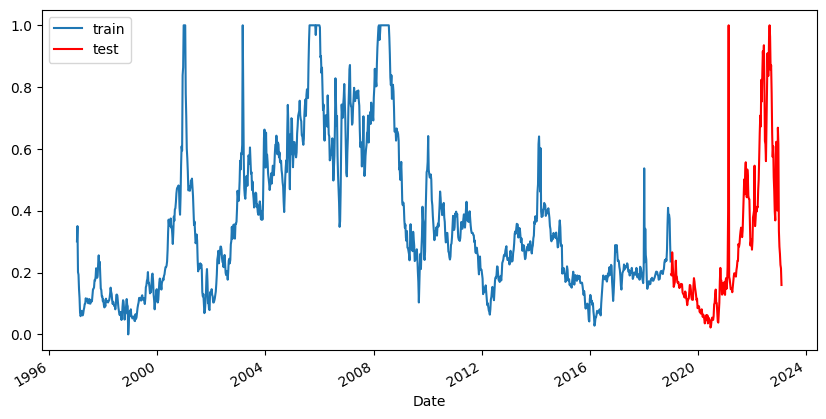

In [ ]:
ax = train_data.plot(figsize=(10, 5))
test_data.plot(ax=ax, color="r")
plt.legend(["train", "test"])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)

train_set = windowed_dataset(series=train_data, batch_size=32,
                                 n_past=60, n_future=60,
                                 shift=1)
valid_set = windowed_dataset(series=test_data, batch_size=32,
                                 n_past=1)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                               strides=1, padding="causal",
                               activation="relu",
                               input_shape=[None, len(df.columns)]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1)
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 64)          384       
                                                                 
 bidirectional (Bidirectiona  (None, None, 100)        46000     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 100)        60400     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, None, 100)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 100)        6

In [ ]:
optimizer = tf.keras.optimizers.Adam()
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
    )
history = model.fit(
    train_set,
    batch_size=32, 
    epochs=100, 
    validation_data=valid_set
    )

Epoch 1/100
33/33 [==============================] - 32s 444ms/step - loss: 0.0334 - mae: 0.1899 - val_loss: 0.0659 - val_mae: 0.2653
Epoch 2/100
33/33 [==============================] - 9s 287ms/step - loss: 0.0278 - mae: 0.1686 - val_loss: 0.0604 - val_mae: 0.2450
Epoch 3/100
33/33 [==============================] - 8s 243ms/step - loss: 0.0407 - mae: 0.2263 - val_loss: 0.0535 - val_mae: 0.2217
Epoch 4/100
33/33 [==============================] - 9s 266ms/step - loss: 0.0399 - mae: 0.2291 - val_loss: 0.0487 - val_mae: 0.2062
Epoch 5/100
33/33 [==============================] - 9s 278ms/step - loss: 0.0356 - mae: 0.2126 - val_loss: 0.0460 - val_mae: 0.1980
Epoch 6/100
33/33 [==============================] - 9s 278ms/step - loss: 0.0374 - mae: 0.2287 - val_loss: 0.0431 - val_mae: 0.1905
Epoch 7/100
33/33 [==============================] - 8s 244ms/step - loss: 0.0362 - mae: 0.2232 - val_loss: 0.0417 - val_mae: 0.1874
Epoch 8/100
33/33 [==============================] - 8s 245ms/step -

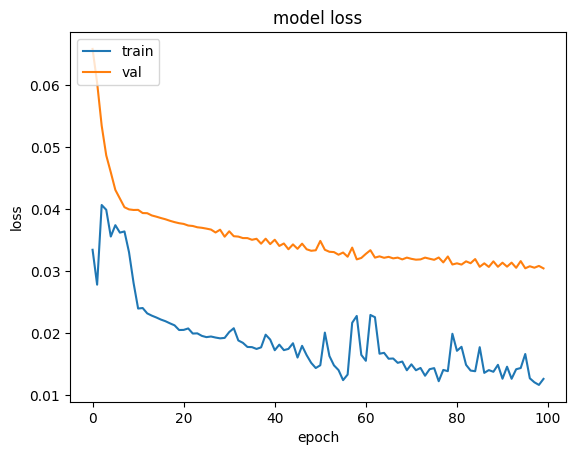

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()